# Inference

This notebook enables to predict the closest images of a sketch. 

In [1]:
# Imports
import json
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams['axes.titlesize'] = 15

In [10]:
from src.data.loader_factory import load_data
from src.data.utils import default_image_loader
from src.models.encoder import EncoderCNN
from src.models.utils import load_checkpoint, get_model, get_dataset_dict
from src.models.test import get_test_data
from src.models.metrics import get_similarity

In [11]:
class Args:
    dataset = "sketchy"
    data_path = "../io/data/raw"
    emb_size = 256
    grl_lambda = 0.5
    nopretrain = False
    epochs = 1000
    batch_size = 10
    seed = 42
    load = None
    early_stop = 20
    ngpu = 1
    prefetch = 2
    log = "../io/models/"
    log_interval = 20
    attn = True
    plot = False
    cuda = False
    save = ''
    load_embeddings = '../io/data/processed/embeddings.ending'
    best_model = '../io/models/best_model_sketchy_epoch42/checkpoint.pth'
    
args = Args()

In [12]:
NUM_CLOSEST = 4
NUMBER_RANDOM_IMAGES = 20

In [13]:
def get_processed_images(args, dataset_type):

    dict_path = args.load_embeddings.replace('.ending', '_' + args.dataset + '_dict_class.json')
    with open(dict_path, 'r') as fp:
        dict_class = json.load(fp)
    
    array_path = args.load_embeddings.replace('.ending', '_' + args.dataset + '_' + dataset_type + '_array.npy')
    with open(array_path, 'rb') as f:
        images_embeddings = np.load(f)

    meta_path = args.load_embeddings.replace('.ending', '_' + args.dataset + '_' + dataset_type + '_meta.csv')
    df = pd.read_csv(meta_path, sep=' ')
    
    
    return dict_class, df['fnames'].values, df['classes'].values, images_embeddings

## Inference

In [27]:
class Inference():
    
    def __init__(self, args, dataset_type):
        
        self.args = args
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.loader = default_image_loader

        self.im_net, self.sk_net = get_model(args, args.best_model)
        self.im_net.eval()
        self.sk_net.eval()
        torch.set_grad_enabled(False)
        
        self.prediction_folder = os.path.join(args.best_model.rstrip('checkpoint.pth'), 'predictions')
        if not os.path.exists(self.prediction_folder):
            os.makedirs(self.prediction_folder)
        
        dataset = args.dataset
        if dataset in ['sketchy', 'tuberlin', 'quickdraw']:
            self.dict_class, self.images_fnames, self.images_classes, self.images_embeddings = get_processed_images(args, dataset_type)
            self.sketchy_limit, self.tuberlin_limit = None, None
            
        elif dataset in ['sk+tu', 'sk+tu+qd']:
            args.dataset = 'sketchy'
            dict_class_sk, self.images_fnames, self.images_classes, self.images_embeddings = get_processed_images(args, dataset_type)
            self.sketchy_limit = len(self.images_fnames)
            self.tuberlin_limit = None
            
            args.dataset = 'tuberlin'
            dict_class_tu, images_fnames, images_classes, images_embeddings = get_processed_images(args, dataset_type)
            self.dict_class = [dict_class_sk, dict_class_tu]
            self.images_fnames = np.concatenate((self.images_fnames, images_fnames), axis=0)
            self.images_classes = np.concatenate((self.images_classes, images_classes), axis=0)
            self.images_embeddings = np.concatenate((self.images_embeddings, images_embeddings), axis=0)
            
            
            if dataset  == 'sk+tu+qd':
                args.dataset = 'quickdraw'
                self.tuberlin_limit = len(self.images_fnames)
                dict_class_qd, images_fnames, images_classes, images_embeddings = get_processed_images(args, dataset_type)
                
                self.dict_class.append(dict_class_qd)
                self.images_fnames = np.concatenate((self.images_fnames, images_fnames), axis=0)
                self.images_classes = np.concatenate((self.images_classes, images_classes), axis=0)
                self.images_embeddings = np.concatenate((self.images_embeddings, images_embeddings), axis=0)
        else:
            raise Exception(args.dataset + ' not implemented.')
        args.dataset = dataset
    
    def random_images_inference(self, args):
        _, _, [test_sk_loader, _], _ = load_data(args, self.transform)
        rand_samples_sk = np.random.randint(0, high=len(test_sk_loader), size=NUMBER_RANDOM_IMAGES)
                
        for i in range(len(rand_samples_sk)):
            _, sketch_fname, _ = test_sk_loader[rand_samples_sk[i]]
            self.inference_sketch(sketch_fname, plot=True)
        
    def inference_sketch(self, sketch_fname, plot=True):
        ''' Process a sketch'''
        
        sketch = self.transform(self.loader(sketch_fname)).unsqueeze(0) # unsqueeze because 1 sketch (no batch)
        sketch_embedding, _ = self.sk_net(sketch)
        self.get_closest_images(sketch_embedding)
        
        if plot:
            self.plot_closest(sketch_fname)
        
    def get_closest_images(self, sketch_embedding):
        '''
        Based on a sketch embedding, retrieve the index of the closest images
        '''
        similarity = get_similarity(sketch_embedding.detach().numpy(), self.images_embeddings)
        arg_sorted_sim = (-similarity).argsort()
        
        self.sorted_fnames = [self.images_fnames[i]
                              for i in arg_sorted_sim[0][0:NUM_CLOSEST + 1]]
        self.sorted_labels = [self.images_classes[i]
                              for i in arg_sorted_sim[0][0:NUM_CLOSEST + 1]]
        
    def plot_closest(self, sketch_fname):
        fig, axes = plt.subplots(1, NUM_CLOSEST + 1, figsize=(20, 8))

        sk = mpimg.imread(sketch_fname)
        axes[0].imshow(sk)
        axes[0].set(title='Sketch \n Label: ' + sketch_fname.split('/')[-2])
        axes[0].axis('off')
        
        for i in range(1, NUM_CLOSEST + 1):
            im = Image.open('../' + self.sorted_fnames[i-1])
            im = im.resize((400, 400))
            
            axes[i].imshow(im)
            dict_class = get_dataset_dict(self.dict_class, self.sorted_labels[i-1], self.sketchy_limit, self.tuberlin_limit)
            axes[i].set(title='Closest image ' + str(i) + 
                        '\n Label: ' + dict_class[str(self.sorted_labels[i-1])])
            
            axes[i].axis('off')
        plt.subplots_adjust(wspace=0.25, hspace=-0.35)
        
        img_name = '_'.join(sketch_fname.split('/')[-2:])
        plt.savefig(os.path.join(self.prediction_folder, img_name))

In [28]:
args.dataset = 'sk+tu+qd'
inference_test = Inference(args, 'test')

# Resuts per multiple randomly selected images

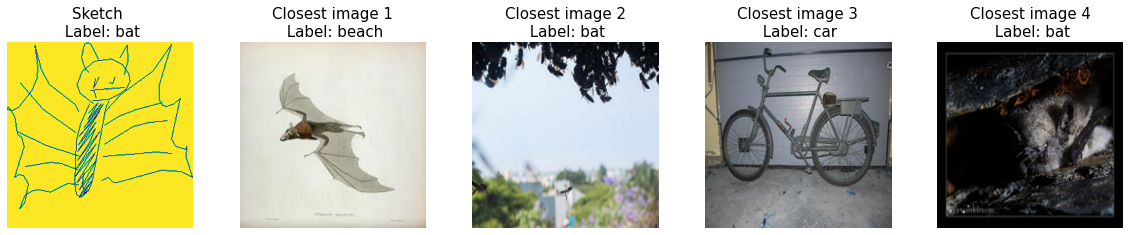

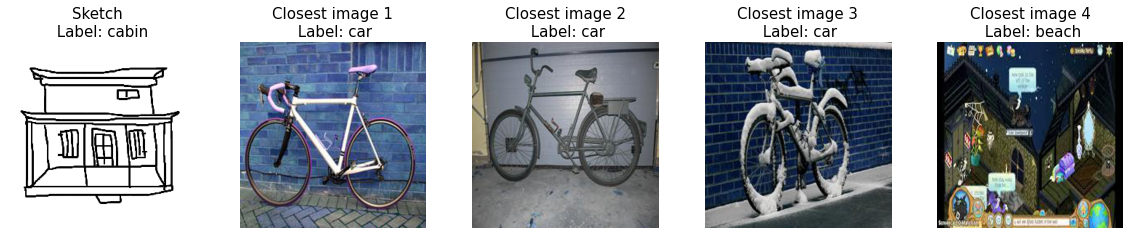

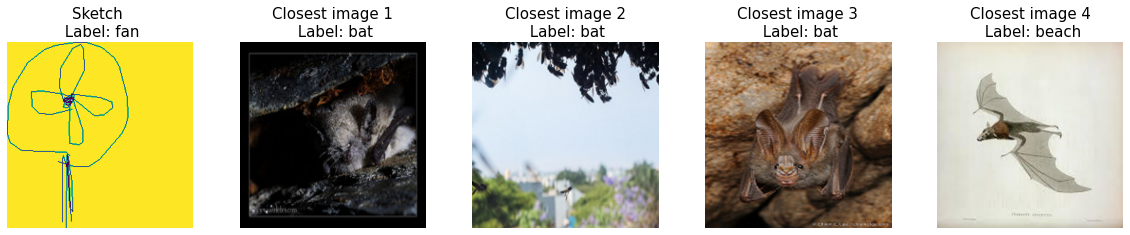

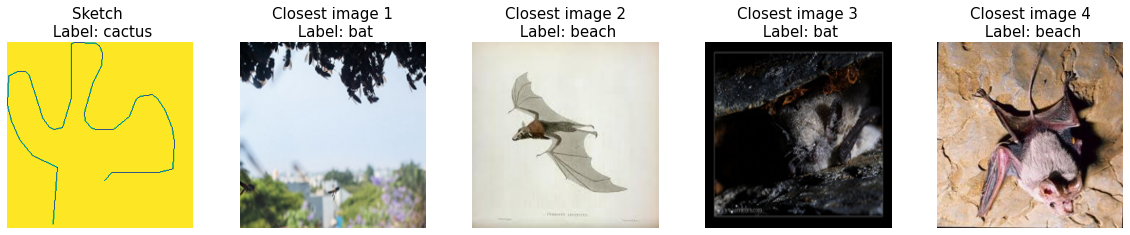

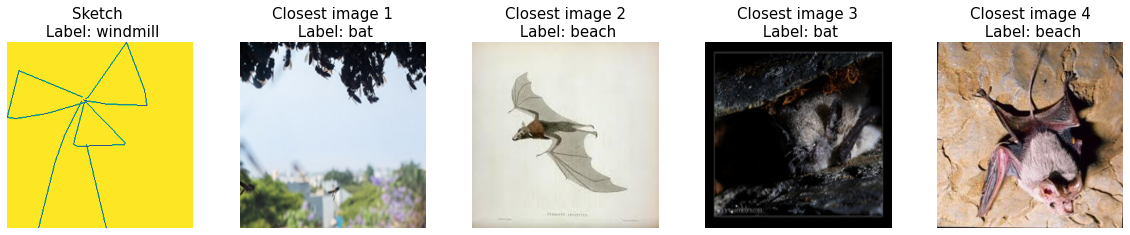

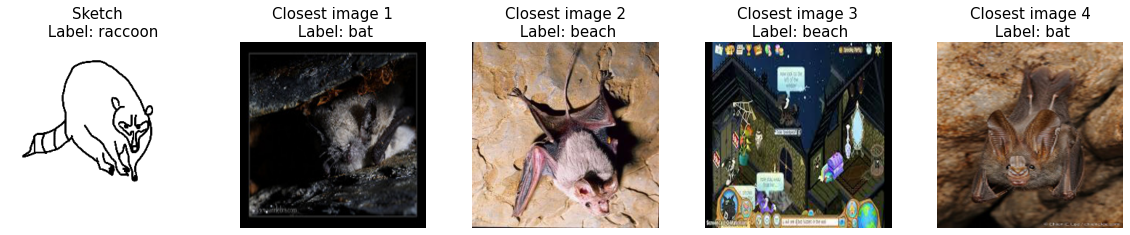

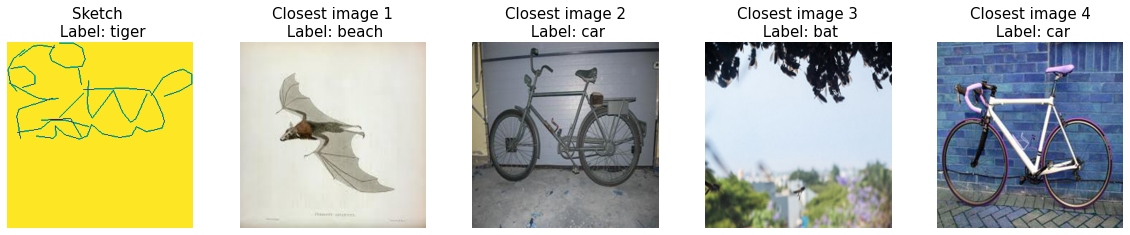

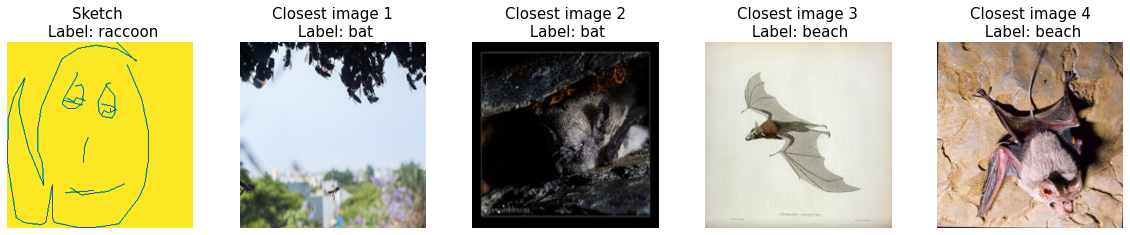

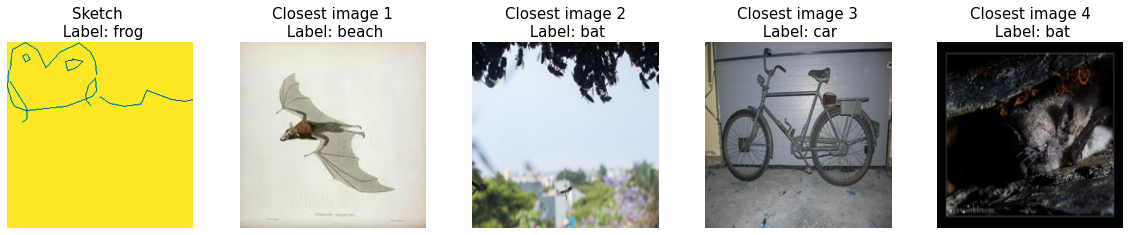

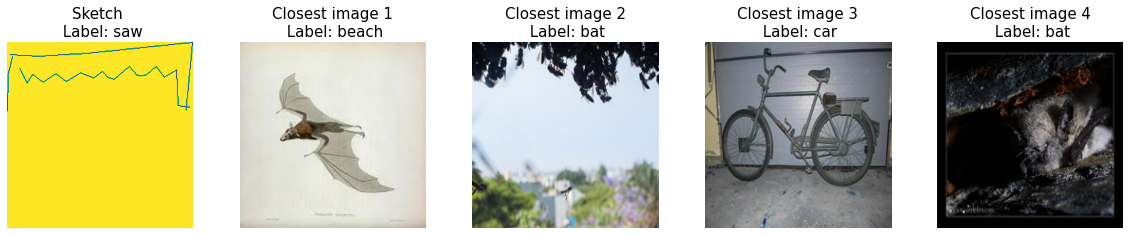

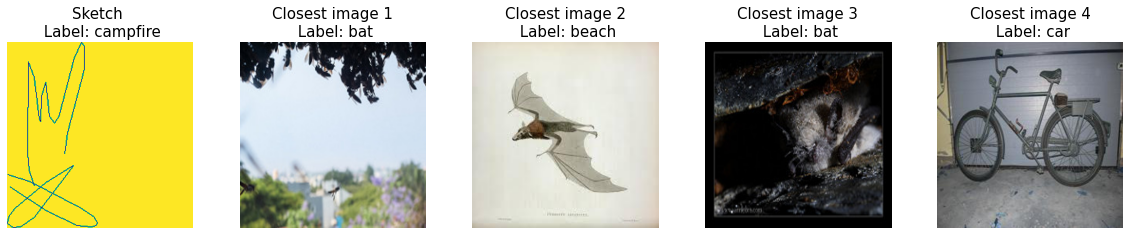

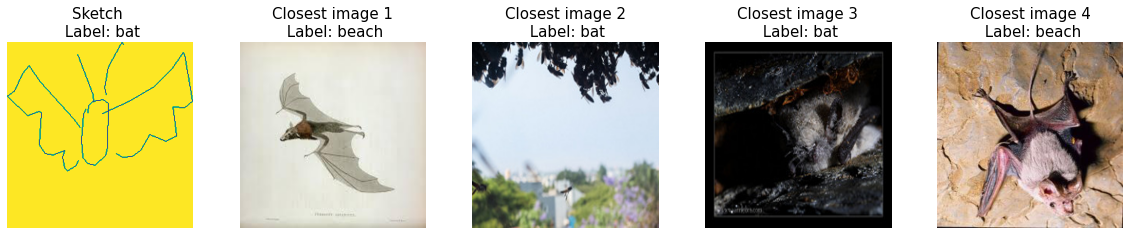

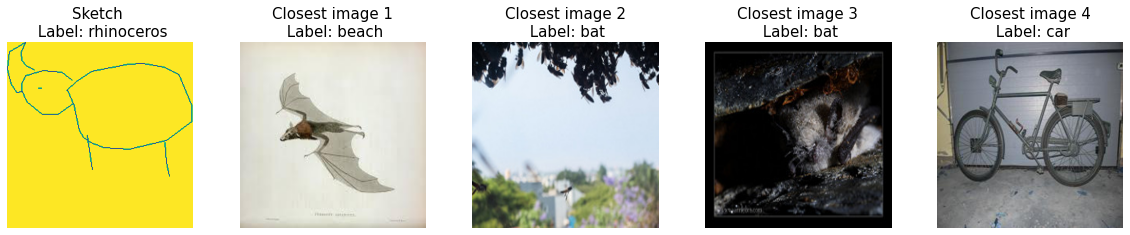

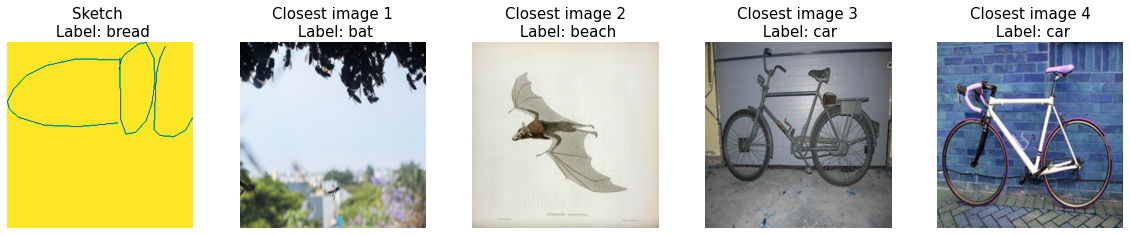

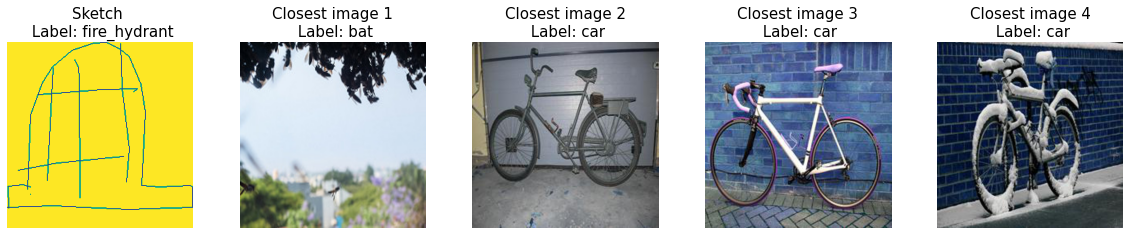

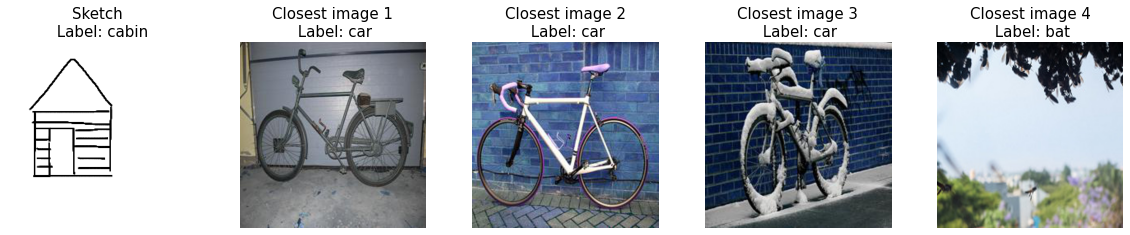

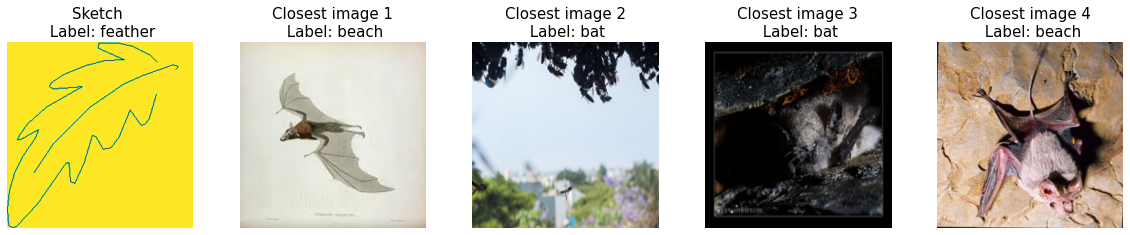

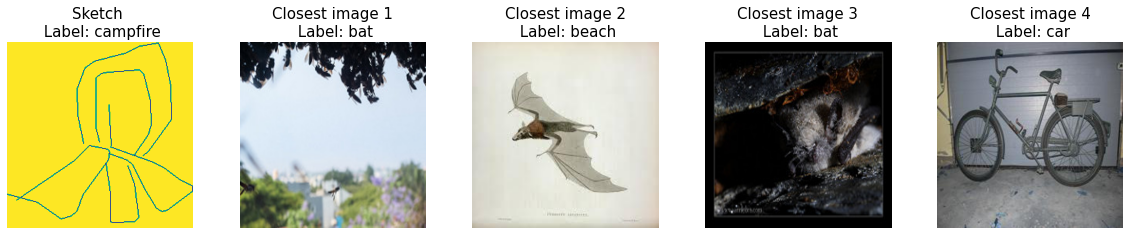

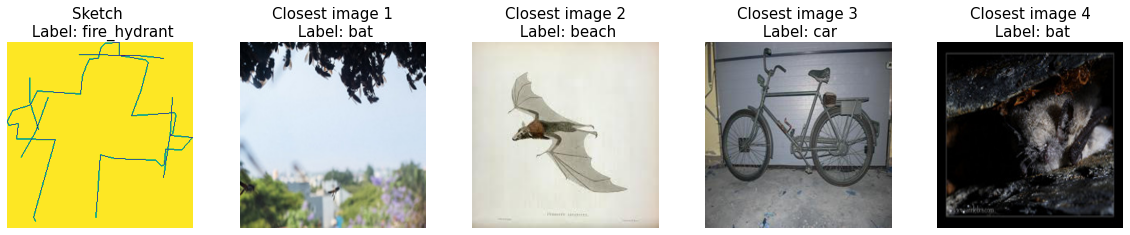

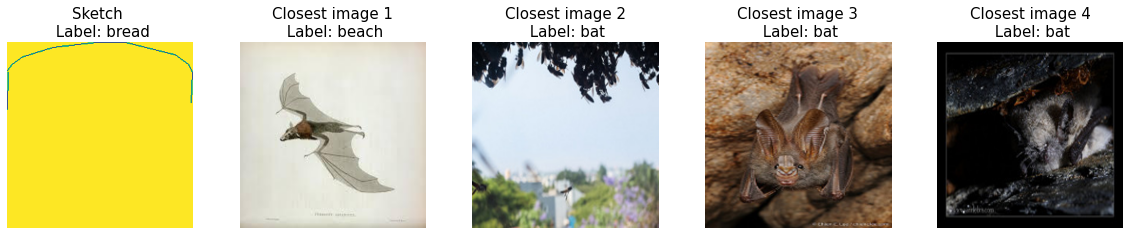

In [29]:
inference_test.random_images_inference(args)

# Results per 1 image

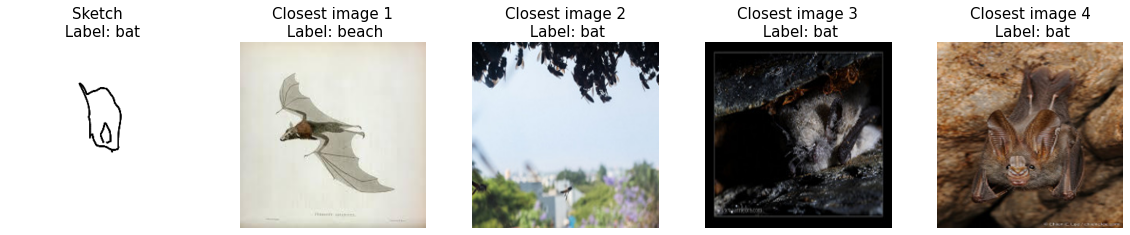

In [30]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/bat/n02139199_1332-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

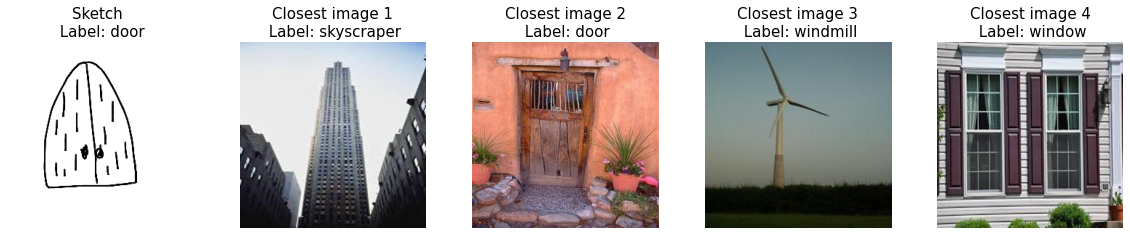

In [124]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/door/n03222176_681-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

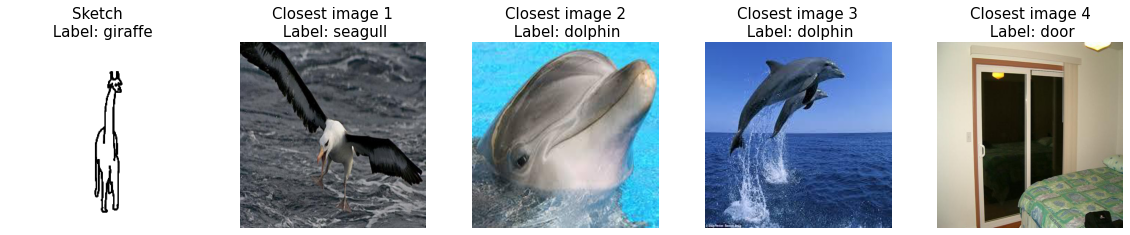

In [125]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/giraffe/n02439033_67-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

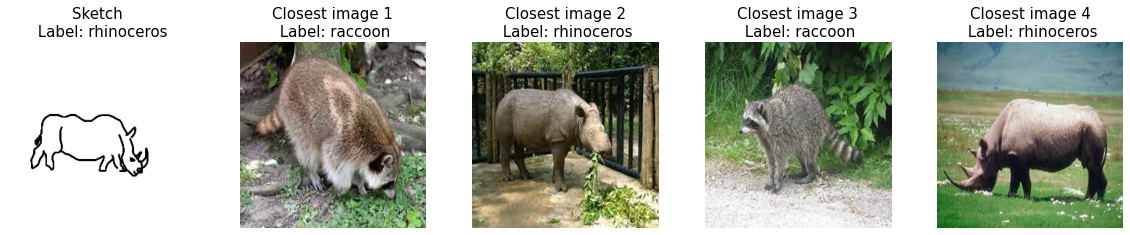

In [126]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/rhinoceros/n02391994_135-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

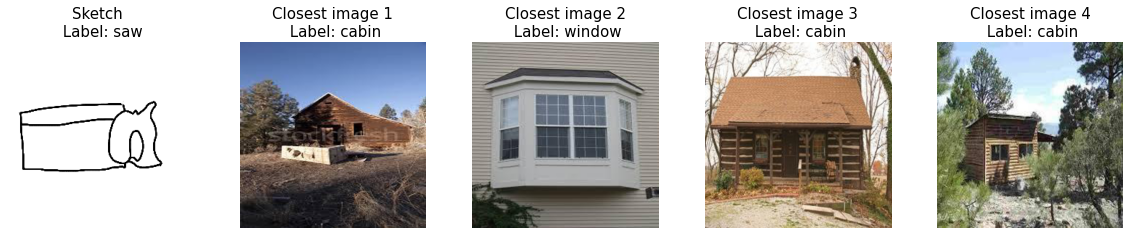

In [127]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/saw/n02770585_1371-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

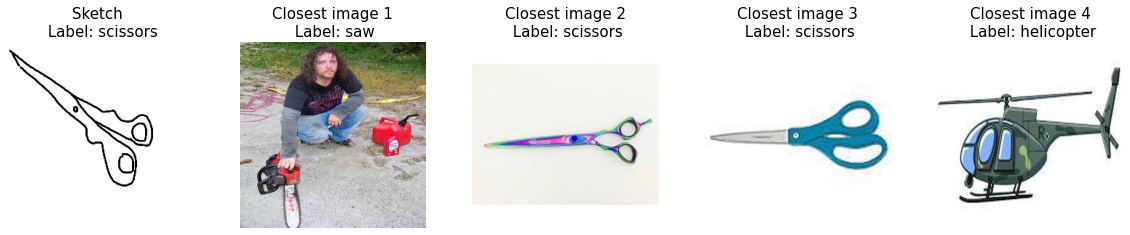

In [128]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/scissors/n03044934_5634-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

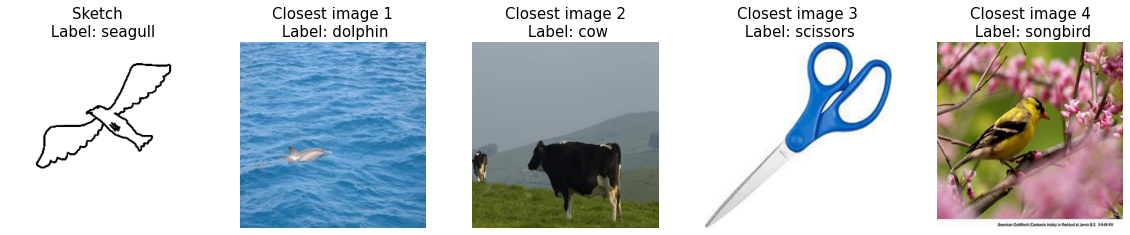

In [129]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/seagull/n02041246_30-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

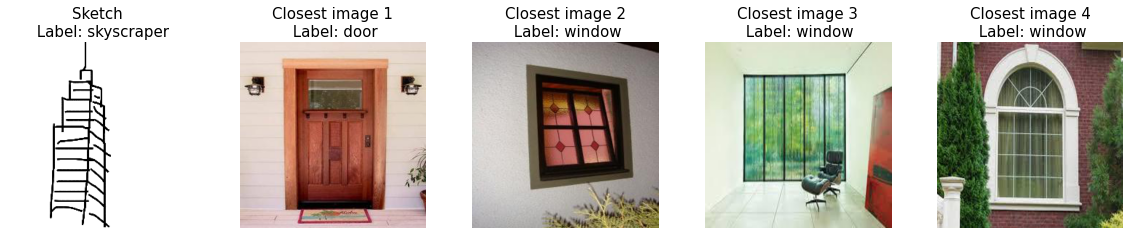

In [130]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/skyscraper/n04233124_498-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

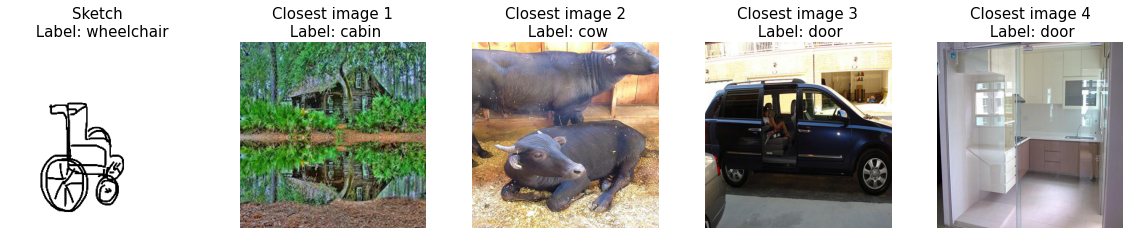

In [131]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/wheelchair/n04576002_150-2.png'
inference_test.inference_sketch(sketch_fname, plot=True)